# Vaccines Global Trade Network: Analysis & Forecasting with ARIMA and Holt-Winters Exponential Smoothing

### Author: Georgios Spyrou
### Date: 27/11/2020

<img src="https://www.our-voices.org.uk/assets/images/Network-diagram.png" width=520 height=240 />

## Sections

- <a href='#project_purpose' style="text-decoration: none\">Project Purpose</a>
- <a href='#data_retrieval' style="text-decoration: none\">Part 1: Data Retrieval</a>
- <a href='#data_cleaning_and_eda' style="text-decoration: none\">Part 2: Data Cleaning and Exploratory Data Analysis</a>
- <a href='#forecasting_models' style="text-decoration: none\">Part 3: Time Series Analysis: Forecasting Models</a>
    - <a href='#arima' style="text-decoration: none\">Autoregressive Integrated Moving Average (ARIMA)</a>
        - <a href='#arima_definition' style="text-decoration: none\">ARIMA definition</a>
        - <a href='#autocorel_lag_plot' style="text-decoration: none\">Autocorrelation, Lag Plot and Stationarity</a>
    - <a href='#hwes' style="text-decoration: none\">Holt-Winters Exponential Smoothing (HWES)</a>

<a id="project_purpose"></a>
## Project Purpose

Scope of this project is to replicate the global trade network of human vaccines around the globe for a variety of years (current data span from 2010 to 2019). Through plotting and statistical analysis, we want to identify informative patterns on how different countries change their import/export activity throughout the years. By using observations falling in the aforementioned timeframe, we will attempty to predict future values of trade the activity between any two pair of countries.

<a id="data_retrieval"></a>
## Part 1: Data Retrieval

In order to find and retrieve data we have utilised the UN Comtrade API (https://comtrade.un.org/Data ). This is a great place if someone wants to find data regarding exports/impors of countries around the world, pretty much for any product/service. The data are very well documented and visualized on the website, and it's easy to do some exploration and locate data that seem interesting for your project.

Therefore, after I managed to identify the relevant data that I wanted to work with (vaccines for human medicine), I had to find a way to leverage the API to get my data. Even though the website allows us to download sample CSV files, if we wanted to do that for multiple years and countries it would take a lot of time. Hence, I have decided to approach the data retrieval from an automation standpoint to avoid doing this manually - as it would be very labor intensive.

Before we jump to the part of how we are going to automate the data retrieval, it might worths it to explain what exactly we are aiming to retrieve.


The UN Comtrade database is giving us the opportunity to pick data for a plethora of goods and services. My first task was to find the specific code that corresponds to human vaccines. After a bit of research we have found that this code is *300220*, which is a unique value that will allow us to only pick data for this good/product. After we identified the product code, we have to decide on the time range that we want to pick data for. This can quickly get tricky as the database does not allow you to pick many years/countries all at once. But for now lets say that the scope of interest was *monthly* data from 2010 to 2019, for as many countries as possible - mainly because there are countries which do not seem to import/export vaccines on a specific year or there is no relevant information about them for that year.

In [1]:
import requests
import csv
import json
import time
import os

# Setting up the parameters for the API calls to receive the data
max_rec = 100000
output_fmt = 'csv'
trade_type = 'C'            # Commodities
frequency = 'M'             # Monthly
px = 'HS'                   # Classification for products
cc = 300220                 # Subcategory --> 300220 code for Vaccines
reporter = 'all'
partner = 'all'                 
rg ='all'

# Connection string to comtrade.un.org based on the parameters above
api_call_string = f'http://comtrade.un.org/api/get?max={max_rec}&type={trade_type}&freq={frequency}&px={px}&ps=year&r=reporter&p={partner}&rg={rg}&cc={cc}&fmt={output_fmt}'

After we set up the string that will be used to do the appropriate API calls, it's time create a function that will use this string to retrieve the data and generate the csv files.

In [2]:
def getDataCall(api_string: str, reporterid: str, reportername: str, year: int, out_folder: str) -> None:
    """
    Create a .csv file that contains the monthly data as received from  https://comtrade.un.org/Data/, for a specified year.

    Args:
    ----
        api_string: String that contains the URL for the API call. The string already contains all the paremeters required for the call.
        reporterid, reportername: Id and Name of the country of interest.
        year: Specify year of interest.
    Returns:
    -------
        None: The output is a .csv file that contains the data for a specified year.
    """
    csv_by_year_out_loc = os.path.join(out_folder, f'{year}')
    if not os.path.exists(csv_by_year_out_loc):
        os.makedirs(name=csv_by_year_out_loc)

    api_string = api_string.replace('year', f'{year}').replace('reporter', f'{reporterid}')
    print(api_string)

    response = requests.get(url=api_string, verify=False)

    if response.status_code != 200:
        print('Could not access the API!')
    else:
        decoded_data = response.content.decode('utf-8')
        csv_file = csv.reader(decoded_data.splitlines())
        datalines = list(csv_file)

        with open(os.path.join(csv_by_year_out_loc, f'Comtrade_Vaccines_Data_{reportername}_{year}.csv'), 'w', newline='') as f:
            writer = csv.writer(f, delimiter=',')
            writer.writerows(datalines)

Note that this call will run for *each* country, therefore we will end up with a lot of csv files. The country codes can be found here: https://comtrade.un.org/Data/cache/reporterAreas.json

In [ ]:
reporters_url = 'https://comtrade.un.org/Data/cache/partnerAreas.json'
reporters_resp = requests.get(url=reporters_url)
json_data = json.loads(reporters_resp.text)

reporters_list = [rep for rep in json_data['results']]

# Get the data as separate csv files, each for every year of interest
years_ls = [2017]
outputFilesFolder = f'CSVFiles\\'

In [ ]:
for api_check, repd in enumerate(reporters_list):
    # Need to make the script to sleep every 100 calls, as the API is blocking us for an hour for every 100 calls.
    if api_check !=0 and api_check % 100 == 0:
        time.sleep(3600)
    countryname = repd['text']
    c_id = repd['id']
    print(f'\nCountry..: {countryname}')
    for year in years_ls:
        print(f'\nReceiving the data for {year} from https://comtrade.un.org/...\n')
        getDataCall(api_call_string, reporterid=c_id, reportername=countryname, year=year, out_folder=outputFilesFolder)
        time.sleep(6)

At this point, we have successfully get the data for every country that we cound find a corresponding country code. That said, as we mentioned before there are some countries that contain no data for a specific year - which is might be for many reasons but this is out of the scope of this project. Hence, after we have ended up with multiple csv files , one for each country , we can repeat this process for as many years as we want to. I have repeated it for years from 2010 to 2019.

As you can probably imagine this process generated over 1000 csv files (10 years x over 100 countries). Hence it was necessary to perform some data cleaning operations in the directory that the files were created. The main task was to merge all this files for a specific year (e.g. all countries for 2017 merged to a common csv file), and at the same time delete all the files from the directory that contained no data.

In order to do that we have created a script to automatically do this for us, but as it might not be that of an interesting task we are going to leave it outside of this notebook. The code that completes the csv cleaning task can be found here: https://github.com/gpsyrou/Vaccines_Trade_Network/blob/master/data_cleaning.py

<a id="data_cleaning_and_eda"></a>
## Part 2: Exploratory Data Analysis & Data Cleaning

Now that we have our data organized into separate csv files by year, we can start the task of exploring what we actually got from the data retrieval process.

**Note**: Frow now on you are going to see two packages, one named **_Functions_** and one named **_VaccinesTradeNetworkClass_**. Please note that these are custom packages that I have created for the purposes of this project. The first one contains some functions that we will keep using for our EDA tasks, while the VaccinesTradeNetworkClass one will be used later on, when we jump into creating out network graph as well as the time series objects.

In [1]:
import os
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

project_dir = r'D:\GitHub\Projects\Comtrade_Network'
os.chdir(project_dir)

# Custom packages
from utilities import trade_network_functions as tnf
from VaccinesTradeNetworkClass import VaccinesTradeNetwork

# Plotting and graphs
import matplotlib.pyplot as plt
import seaborn as sns

csv_files_loc = os.path.join(project_dir, 'Merged_CSVs')
maindf = pd.concat([pd.read_csv(os.path.join(csv_files_loc, file)) for file in os.listdir(csv_files_loc)])

At this stage we need to explore the dataset and identify any potential issues in the data that require cleaning, and also make sure that we understand the features.

In [2]:
summary = maindf.describe()
summary

Year         Period  Aggregate Level  Is Leaf Code  \
count  174733.000000  174733.000000         174733.0      174733.0   
mean     2014.509721  201457.467548              6.0           1.0   
std         2.784246     278.388706              0.0           0.0   
min      2010.000000  201001.000000              6.0           1.0   
25%      2012.000000  201208.000000              6.0           1.0   
50%      2015.000000  201502.000000              6.0           1.0   
75%      2017.000000  201705.000000              6.0           1.0   
max      2019.000000  201912.000000              6.0           1.0   

       Trade Flow Code  Reporter Code  Reporter ISO   Partner Code  \
count    174733.000000  174733.000000           0.0  174733.000000   
mean          1.573652     430.022137           NaN     383.477483   
std           0.534287     269.904852           NaN     280.672337   
min           1.000000       8.000000           NaN       0.000000   
25%           1.000000     208.000000           NaN     124.000000   
50%           2.000000     392.000000           NaN     364.000000   
75%           2.000000     699.000000           NaN     643.000000   
max           4.000000     894.000000           NaN     899.000000   

       Partner ISO  2nd Partner Code    ...     Qty  Alt Qty Unit Code  \
count          0.0               0.0    ...     0.0                0.0   
mean           NaN               NaN    ...     NaN                NaN   
std            NaN               NaN    ...     NaN                NaN   
min            NaN               NaN    ...     NaN                NaN   
25%            NaN               NaN    ...     NaN                NaN   
50%            NaN               NaN    ...     NaN                NaN   
75%            NaN               NaN    ...     NaN                NaN   
max            NaN               NaN    ...     NaN                NaN   

       Alt Qty Unit  Alt Qty  Netweight (kg)  Gross weight (kg)  \
count           0.0      0.0    1.459460e+05                0.0   
mean            NaN      NaN    2.202360e+04                NaN   
std             NaN      NaN    1.922478e+06                NaN   
min             NaN      NaN    0.000000e+00                NaN   
25%             NaN      NaN    5.000000e+01                NaN   
50%             NaN      NaN    3.650000e+02                NaN   
75%             NaN      NaN    2.100000e+03                NaN   
max             NaN      NaN    4.681763e+08                NaN   

       Trade Value (US$)  CIF Trade Value (US$)  FOB Trade Value (US$)  \
count       1.747330e+05                    0.0                    0.0   
mean        5.059609e+06                    NaN                    NaN   
std         3.375567e+07                    NaN                    NaN   
min         0.000000e+00                    NaN                    NaN   
25%         1.596700e+04                    NaN                    NaN   
50%         1.376720e+05                    NaN                    NaN   
75%         1.016600e+06                    NaN                    NaN   
max         1.867086e+09                    NaN                    NaN   

           Flag  
count  174733.0  
mean        0.0  
std         0.0  
min         0.0  
25%         0.0  
50%         0.0  
75%         0.0  
max         0.0  

[8 rows x 29 columns]

As we can see from the summary, few of the features do not seem to provide useful information for our analysis, as they either contain only empty values (e.g. 'Qty') or they contain fixed values (e.g.'Aggregate Level'). Therefore we will exclude the useless columns from our dataset to reduce the noise and the dimensions of the feature space.

Note: More information regarding the feautures can be found here: https://comtrade.un.org/data/MethodologyGuideforComtradePlus.pdf

In [3]:
useful_features_ls = ['Year', 'Period', 'Reporter Code', 'Reporter', 'Partner Code',
                      'Partner', 'Trade Flow', 'Commodity', 'Netweight (kg)', 'Trade Value (US$)']
df = maindf[useful_features_ls]

In [4]:
df['Trade Flow'].unique()

array(['Imports', 'Exports', 'Re-exports', 'Re-imports'], dtype=object)

We will consider both 'Re-imports' and 'Re-exports' as 'Imports' and 'Exports' respectively and we will drop the entries where we dont have info about the trade flow.

In [5]:
trade_flow_dict = {'Re-imports':'Imports', 
                   'Re-exports':'Exports',
                   'Imports':'Imports', 
                   'Exports':'Exports'}

df['Trade Flow'] = df['Trade Flow'].map(trade_flow_dict)

In [6]:
df.Partner.unique()

df['Partner'].replace(
    to_replace='United States of America',
    value='USA',
    inplace=True
)

df['Reporter'].replace(
    to_replace='United States of America',
    value='USA',
    inplace=True
)

Now we can observe that we have a node called 'World' but we would like to  analyze the trade relationships between specific countries. Thus we will exclude from the analysis the cases where the reporter or partner is 'World'. Finally, **Period** will be the datetime column.


In [7]:
df = df[df.Partner != 'World']

df['Period'] = pd.to_datetime(df['Period'], format='%Y%m')

Except the nodes of our analysis which will correspond to countries, the other main features of interest are the **Netweight** of the export/import in kilograms as well as the **Trade Value in US dollars($)**.

Now we are in a position where we can start the data visualization part, to get a better understanding of our dataset. Therefore, lets find the top countries that import/export vaccines in terms of US dollars($).

At this point its necessary to introduce two functions for our EDA analysis. One function is being used in order to calculate the statistics of interest, while the second one is to plot the results. Both of these functions our packaged in *Functions* as we mentioned above, but as they might be interesting we are also going to include them into this notebook.

In [8]:
def getAggregateStatistics(df: pd.core.frame.DataFrame, feature: str,
                     kind: str, year: str) -> pd.core.frame.DataFrame:
    """
    Given a dataframe and a feature column (numerical), identify the top
    importers/exporters.
    
    Args:
    ----
        df: DataFrame that contains the data and the required features.
        feature: Numerical feature to aggregate (e.g. 'Trade Value (US$)', 'Netweight (kg)')
        kind: 'Imports', 'Exports'
        year: Specify year of interest or 'all' for all years.
    Returns:
    -------
        df_sorted: Sorted dataframe that contains the aggregated values.
    """
    if year == 'all':
        df = df.loc[df['Trade Flow'] == kind, [feature,
            'Year', 'Reporter']].groupby(['Year', 'Reporter']).agg(['sum']).reset_index()
    else:
        df = df.loc[(df['Trade Flow'] == kind) &
                    (df['Period'] > f'{year}-01-01') & (df['Period'] <= f'{year}-12-31'), 
                    [feature,'Reporter']].groupby(['Reporter']).agg(['sum']).reset_index()
    
        df['Year'] = int(year)

    df_sorted = df.sort_values(by=(feature,'sum'), ascending=False)
    
    return df_sorted

In [9]:
def barplotTopnCountries(df: pd.core.frame.DataFrame, feature: str,
                      topn: int, kind: str, year: str, figsize=(12,6)) -> None:
    """
    Create a bar plot of the top-N countries compared to an aggregated column.        
    """
    if kind != 'Import' and kind != 'Export':
        raise ValueError('Trade flow is not set to Import or Export')

    plt.figure(figsize=figsize)
    g = sns.barplot(x='Reporter', y=(feature,'sum'), data=df[0:topn],
                    palette='muted')

    if topn > 5 and topn <= 10:
        rot = 0
    elif topn > 10:
        rot = 75
    else:
        rot = 0

    g.set_xticklabels(g.get_xticklabels(), rotation=rot)
    plt.ticklabel_format(style='plain', axis='y')
    if year == 'all':
        plt.title(f'Top-{topn} {kind}ers of vaccines around the globe', fontweight='bold')
    else:
        plt.title(f'Top-{topn} {kind}ers of vaccines around the globe in {year}', fontweight='bold')
    plt.xlabel(f'{kind}er Country')
    if feature == 'Trade Value (US$)':
        plt.ylabel(f'Total amount of {kind}s in US$')
    else:
        plt.ylabel(f'Total amount of {kind}s in Netweight (kg)')
    plt.grid(True, alpha = 0.3)
    plt.show()


The analysis will be focused on Trade Value in US($) dollars, but it can be easily applied to the Netweight of exports/imports.

In [10]:
# Specify the top-n number of countries that we want to plot for
topn = 5

#### 2017

In [11]:
top_importers_2017 = getAggregateStatistics(df, feature='Trade Value (US$)', kind='Imports', year='2017')
top_importers_2017[0:topn]

Reporter Trade Value (US$)  Year
                                  sum      
99              USA        4869975839  2017
11          Belgium        4152214149  2017
102  United Kingdom        2082966657  2017
36           France        1055041985  2017
38          Germany         902588399  2017

#### 2018

In [12]:
top_importers_2018 = getAggregateStatistics(df, feature='Trade Value (US$)', kind='Imports', year='2018')
top_importers_2018[0:topn]

Reporter Trade Value (US$)  Year
                                  sum      
9           Belgium        6205451657  2018
98              USA        5481520861  2018
102  United Kingdom        1931098270  2018
37          Germany        1060640167  2018
35           France         857875223  2018

#### 2019

In [13]:
top_exporters_2019 = getAggregateStatistics(df, feature='Trade Value (US$)', kind='Exports', year='2019')

top_importers_2019 = getAggregateStatistics(df, feature='Trade Value (US$)', kind='Imports', year='2019')

top_importers_2019[0:topn]

Reporter Trade Value (US$)  Year
                                 sum      
8          Belgium        7360332016  2019
75             USA        6830179716  2019
78  United Kingdom        1931609396  2019
57          Poland         641202547  2019
16          Canada         617836218  2019

We can have a look on how to total amount of Trade Value of imports for vaccines is fluctuating during the full scope time period, for a few of the major countries of interest (i.e. countries with high exporting/importing activity).

In [14]:
year = 'all'

top_importers_all_years = getAggregateStatistics(df, feature='Trade Value (US$)', kind='Imports', year=year)

top_importers_all_years = top_importers_all_years.set_index(['Year'])

country_list = ['Belgium', 'Canada', 'United Kingdom', 'USA', 'Poland', 'Japan']

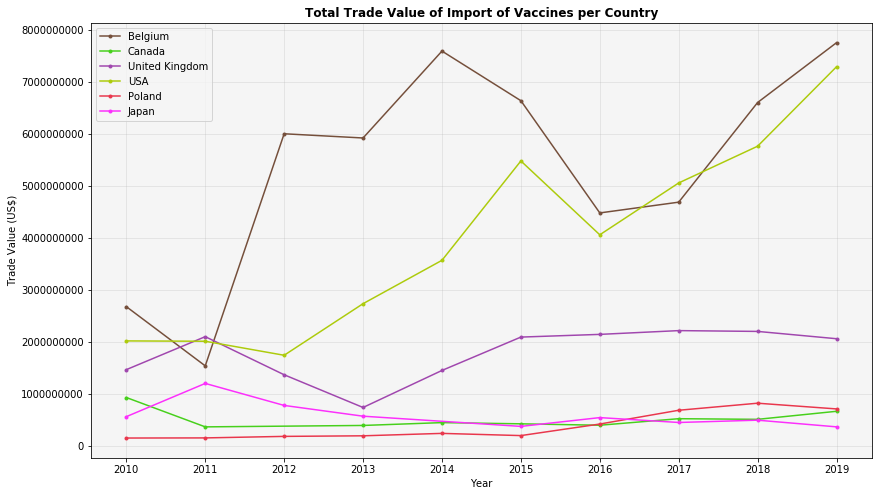

In [15]:
np.random.seed(35)
plt.rcParams['axes.facecolor'] = 'whitesmoke'

plt.figure(figsize=(14,8))
for country in country_list:
    cntry = top_importers_all_years[top_importers_all_years['Reporter'] == country]['Trade Value (US$)']
    plt.plot(cntry.sort_index(axis=0), marker='.', color=np.random.rand(3,), label=country)
plt.xlabel('Year')
plt.xticks(list(df.Year.unique()))
plt.ylabel('Trade Value (US$)')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Total Trade Value of Import of Vaccines per Country', fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

We can also visualize the results for a specific year:

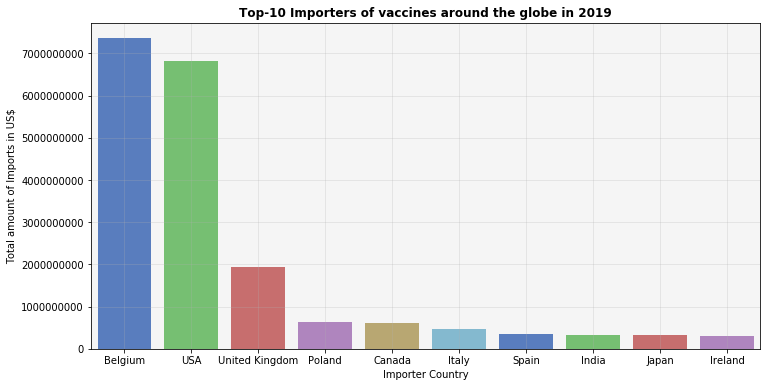

In [16]:
year = '2019'

topn = 10
barplotTopnCountries(df=top_importers_2019, feature='Trade Value (US$)', topn=topn, kind='Import', year=year, figsize=(12,6))

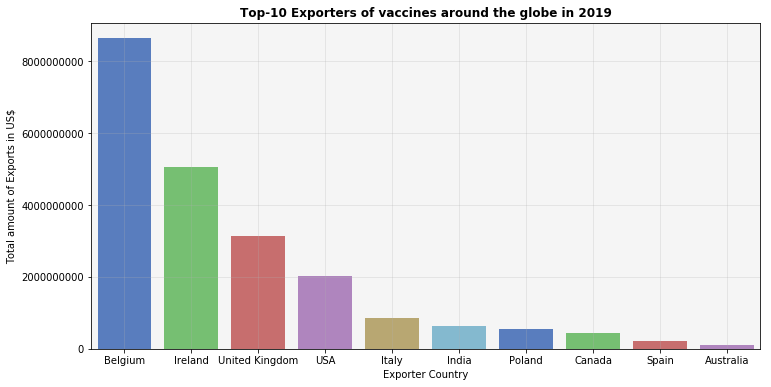

In [17]:
barplotTopnCountries(df=top_exporters_2019, feature='Trade Value (US$)',topn=topn, kind='Export', year=year, figsize=(12,6))

For 2019 we can see that - except the first three countries (Belgium, USA, UK) - the rest of the countries seem to import much less compared with the top-3 importers. At the same Ireland appears to had a huge exporting activity on 2019, while it's not even in the top-15 importers for the same year. 

<a id="forecasting_models"></a>
## Part 3 - Forecasting Models

In this part we are going to focus only at United Kingdom as our base country and perform an in depth analysis about the countries that UK is trading with, attempting to identify interesting patterns in the results. This is going to be done in two different sections. In the first one we will focus at visualizing the variations of imports by month, i.e. we will create a time series object for the base country, where each observation will be the **Total Value** of imports in a specific point in time. Aftewards, we will use the time series data to perform a _prediction_ task where we will test the performance of ARIMA and Holt-Winters Exponential Smoothing (HWES) models in predicting the values for 2019, based on the monthly values between 2010 and 2018. Finally, the second section of the project is focused on Network Analysis, where we will explore the importing/exporting relatioship of countries but this time our main object will be a _network_ of countries, utilizing the _networkx_ (https://networkx.github.io/) python package.

First we are creating the objects that will contain all the information that we need for our analysis. Each object is going to represent a country and in our analysis, as we mentioned previously, we will focus on United Kingdom - but we will attempt to make the codebase as robust as possible, so that the same analysis can be easily performed for any other importer (or exporter) country. 

At this point we will leverage the class **VaccinesTradeNetwork** which is a class that will allow us to create our analysis without having to include the code snipets in the notebook. If you want more information regarding how this class is organized, feel free to have a look at the <a href='https://github.com/gpsyrou/Vaccines_Trade_Network/blob/master/VaccinesTradeNetworkClass.py' style="text-decoration: none">repository.</a> As a matter of fact, I would suggest to look at this link as it will make it much easier to understand what is happening in the background. The reason that I do not include it in the notebook is that the code is quite extensive so it would make it harder to follow along for the reader.

In [18]:
# Create an object for United Kingdom
# We can use the country parameter to focus the analysis to any other valid country
united_kingdom = VaccinesTradeNetwork(df, country='United Kingdom')

We will take into consideration all data that 1) UK is the importer country of vaccines or 2) other countries exporting **to** UK (and thus that makes UK again the importer country). This has been implemented in the *create_trade_flow_df* method, in the **VaccinesTradeNetwork** class. If we would like to change our analysis to exports instead of imports, we could just change the _tradeflow_ parameter.

In [19]:
united_kingdom_imports_df = united_kingdom.create_trade_flow_df(tradeflow='Imports',
                                                        source='Reporter',
                                                        target='Partner')

To make the analysis more straighforward to follow we will focus only at the case where the exporter country is USA (i.e. the trade value of imports of UK from USA).

In [20]:
united_kingdom_ts = united_kingdom.generateTimeSeries(partner_country='USA', timeframe='month')

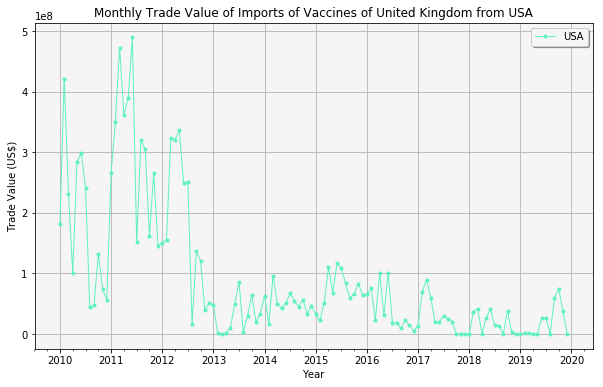

In [21]:
plt.rcParams['axes.facecolor'] = 'whitesmoke'
united_kingdom.plotTimeSeries(partner_list=['USA'], timeframe='month', figsize=(10,6))

Figure 1.1

Our forecasting task will be separated into two parts. We will implement an ARIMA model to predict the monthly values for 2019, based on the values that we have for the period 2010-2018. For the second part will have the same goal but this time we will construct a Holt-Winters Exponential Smoothing model to make the predictions. Finally, we will compare the outputs of both methods and see which one is better for the forecasting task.

<a id="arima"></a>
### Times Series Forecasting with ARIMA

At this stage we are going to fit an _ARIMA_ (Autoregressive Integrated Moving Average) model to forecast the 2019 Trade Value of UK imports of Vaccines from the USA.

ARIMA(p,d,q) is a statistical method (model) for time series analysis, which helps us with the forecasting of future points of a series of observations or just getting a better understanding of our data (e.g. a trend in the data).
<a id="arima_definition"></a>
The main components of an _ARIMA_ model, are:
  
 **1.**  $AR \: (Autoregression)$ : This means that the model is leveraging the dependent relationship between an observation and some number of lagged observations (i.e. we are regressing the variable of interest on it's prior values).
 <a id="point_2"></a>
 
 **2.**   $I \: (Integrated)$ : This is a common step to make the time series stationary, where we are subtracting an observation from an observation at the previous time step.
 
 **3.**  $MA \: (Moving\:Average)$ : The specification indicating that the predictor variable depends linearly on current/past observations. 
 
 **4.**   $p$: Number of lag observations in the model (lag order).
 
 **5.**   $d$: Number of times we subtracted past values from the data (degree of differencing).
 
 **6.**   $q$: Order of the moving average window (moving average).
 
In the next few steps our task is to identify the values of parameters p,d,q from above in order to define the final format of the _ARIMA_ which we will use.

In [22]:
from pandas.tools.plotting import autocorrelation_plot, lag_plot
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

Now before we start building the model we should make sure that we are not violating any assumptions regarding ARIMA models. One of these assumptions is that our Time Series is **stationary** (i.e. the mean and the variance remain constant over time). Please note that when we are saying that a series is stationary we don't mean that the series does not change over time - it means that the _way_ that the series is changing does not vary over time.

By looking at Figure 1.1 we can see that the time series in our case is not stationary and we have a **decreasing trend** (we will name this 'trend'), along with **seasonal trends** (we will name this 'seasonality').



<a id="autocorel_lag_plot"></a>
#### Autocorellatio, Lag Plot and Stationarity


At first we look at the autocorrelation plot of the time series. This plot helps us identify a statistically significant amount of lags for the time series (i.e the lag order). This can be identified by looking at which point our series is between the dashes, which is the significant range.



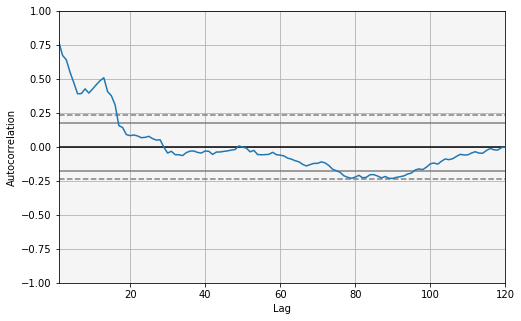

In [35]:
plt.figure(figsize = (8,5))
autocorrelation_plot(united_kingdom_ts['Trade Value (US$)'])

By looking at the plot we can infer that there is a positive correlation between lags 1-30, but it seems to be significant at the first 1 to 18 lags.
Thus a good starting point would be at 8-12 lags.

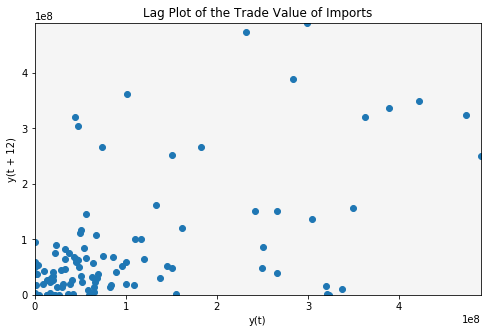

In [23]:
lag_order = 12

# Create a Lag plot
tnf.create_lag_plot(united_kingdom_ts['Trade Value (US$)'], lag = lag_order)

A lag plot is a special type of scatter plot with the two variables $(X,Y)$ “lagged”.

A “lag” is a fixed amount of passing time; One set of observations in a time series is plotted (lagged) against a second, later set of data. 
The $k$th lag is the time period that happened “$k$” time points before time i.
(reference: https://www.statisticshowto.datasciencecentral.com/lag-plot/)

In our case we can see that we have a - somehow - positive correlation and there is a linear pattern (suggesting autocorellation) between time $t$ and $t-k$ where $k$ = lag order.

To check and evaluate the time series for stationarity we will be using a custom function that is using the _Dickey-Fuller_ test.In this test, the null hypothesis is that the Time Series is non-stationary.

In [25]:
# Function that calculates the rolling mean and standard deviation, as well as performing the Dickey-Fuller Test
def check_stationarity(df, window, figsize=(10,6)):
    """
    Function that calculates the rolling mean and standard deviation, 
    as well as performing the Dickey-Fuller Test
    
    Parameters:
    
    df: Time Series object
    window: size of the rolling average window
    
    """ 
    # Calculating rolling mean and standard deviation
    rolling_mn = df.rolling(window).mean()
    rolling_std = df.rolling(window).std()
    
    plt.figure(figsize=figsize)
    plt.plot(df, color = 'blue',label = 'Original TS')
    plt.plot(rolling_mn, color = 'red', label = 'Rolling Mean')
    plt.plot(rolling_std, color = 'black', label = 'Rolling St.Dev.')
    plt.legend(loc = 'best')
    plt.grid(True, color = 'lightgrey')
    plt.title('Rolling Mean & Standard Deviation of the Trade Value of Vaccines', fontsize = 10)
    
    # Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    fuller_test = adfuller(df, autolag = 'AIC')
    results_ts = pd.Series(fuller_test[0:4], index = ['Test Statistic','P-value','#Lags Used','Number of Observations Used'])
    for key,value in fuller_test[4].items():
        results_ts['Critical Value (%s)'%key] = value
    print(results_ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.725599
P-value                          0.417973
#Lags Used                      13.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


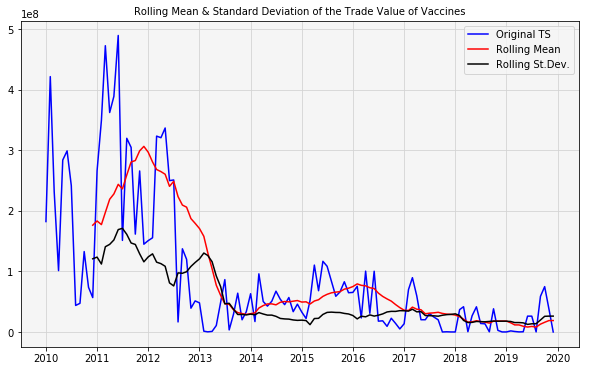

In [26]:
check_stationarity(df=united_kingdom_ts['Trade Value (US$)'], window=lag_order, figsize=(10,6))

We can see that our time series is not stationary yet, as the test statistic is more that the critical values (we are not looking at the absolute values). Therefore we **fail to reject** the null hypothesis.

The reason why this time series is not stationary lies to the fact that we have a clear trend and seasonality in our data, as already mentioned above. One of the most common ways to resolve this issue is by using a technique called _differencing_ (point 2 at ARIMA model explanation <a href='#point_2' style="text-decoration: none\">above</a>). Hence, when it's time to run the ARIMA model we have to make sure to include an **'I'** (integrated) parameter - which will give us the value of the differentiation paremeter (i.e. how many times we are differencing an observation).

Now to define the values for 'p' and 'q', we will use ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function). The ACF is helping us to measure the correlation of our time series with a lagged version of itself, for a specific lag. The PACF is similar to ACF but we are also excluding the variations explained already between an observation and its lagged value.


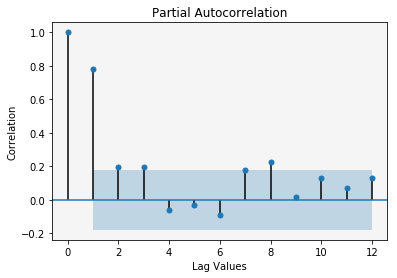

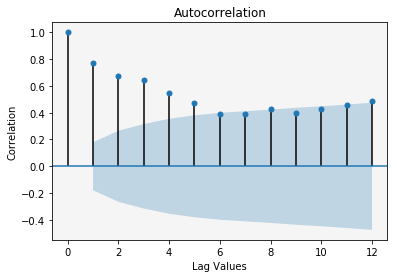

In [39]:
# Partial Autocorrelation Plot
tnf.plot_acf_pacf(united_kingdom_ts['Trade Value (US$)'], lag=lag_order, kind='pacf')

# Autocorrelation plot
tnf.plot_acf_pacf(united_kingdom_ts['Trade Value (US$)'], lag=lag_order, kind='acf')

The PACF and ACF plots indicating that we have clear statistical significance for lags 1 or 8 for PACF (giving us the **p** parameter) and lags 1 to 5 (giving us the **q** paremeter).

Now we are going to split our dataset into train and test sets, where the training set will contain the data for period 2010-2018, and the test set will contain data for 2019. Our task will be - base on the training data - how well we can predict the values for 2019.

In [40]:
train, test = tnf.split_test_train(united_kingdom_ts['Trade Value (US$)'], num_months_test=12)

In [41]:
train.shape, test.shape

((108,), (12,))

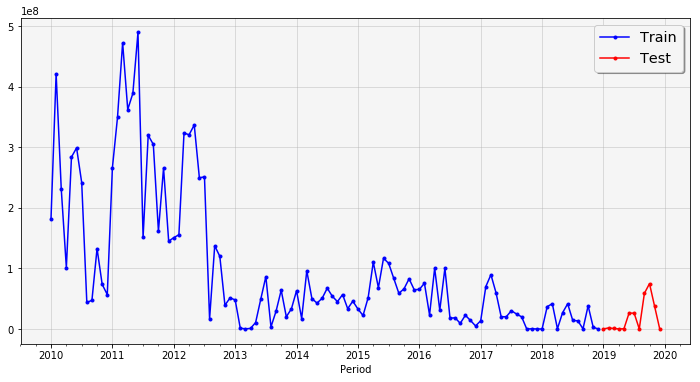

In [42]:
# Plot train and test sets
plt.figure(figsize=(12,6))
train.plot(marker = '.', color = 'blue', label = 'Train')
test.plot(marker = '.', color = 'red', label = 'Test')
plt.legend(loc = 'best', shadow = True, fontsize = 'x-large')
plt.grid(True, alpha=0.5)
plt.show()

We can create multiple ARIMA models and test the different values for p,d,q parameters that we identified above, and we will use the minimum AIC (Akaike information criterion) value to choose the optimal model.

In [43]:
# Possible values for p,d,q paremeters and all of their combinations
p = [8,12] 
d = [1]
q = [1,2,3,4,5]

import itertools
param_combinations = list(itertools.product(p, d, q))

In [ ]:
AIC_results = {}
for perm in param_combinations:
    model = ARIMA(train, order = (perm[0], perm[1], perm[2]))
    model_output = model.fit(disp=0)
    AIC_results[perm] = model_output.aic
    print(f'Paremeter combination: {perm} - AIC score: {model_output.aic}')

We are going to pick the set of parameters that are producing the minimum AIC score, and run our final ARIMA model based on these parameters.

In [45]:
optml_params = min(AIC_results.items(), key=lambda x: x[1])[0] 
optml_params

(12, 1, 2)

In [46]:
# Run the final ARIMA model with the optimal values
p, d, q = optml_params[0], optml_params[1], optml_params[2]

predicted_values_arima = []
series_updated = [x for x in train]

for t in range(len(test)):
    model = ARIMA(series_updated, order = (p,d,q))
    model_output = model.fit(disp=0)
    pred = model_output.forecast()
    yhat = pred[0]
    predicted_values_arima.append(yhat)
    obs = test[t]
    series_updated.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=19334427.465120, expected=64449.000000
predicted=3726928.942780, expected=1806453.000000
predicted=-10233306.141574, expected=846430.000000
predicted=-24682410.436872, expected=124498.000000
predicted=-13283213.269738, expected=356123.000000
predicted=10959987.960482, expected=26184844.000000
predicted=15753124.800084, expected=26145772.000000
predicted=24283139.357564, expected=141569.000000
predicted=20510770.237959, expected=58903494.000000
predicted=38264775.171081, expected=74932830.000000
predicted=35250938.180910, expected=37295621.000000
predicted=33440795.419241, expected=43100.000000


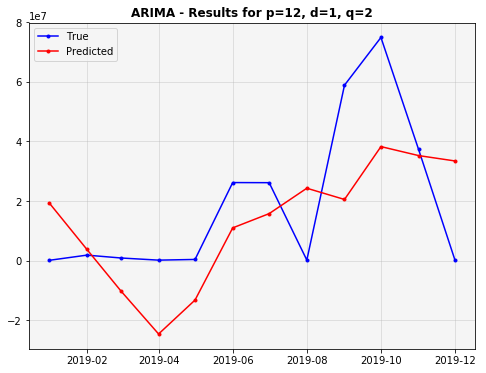

In [47]:
# Compare the predictions visually
plt.figure(figsize=(8,6)),
plt.plot(test, marker='.', color= 'blue', label='True'),
plt.plot(pd.Series(predicted_values_arima, index=test.index), marker='.', color='red', label='ARIMA'),
plt.grid(True, alpha=0.4),
plt.title(f'ARIMA - Results for p={p}, d={d}, q={q}', fontweight='bold'),
plt.legend(loc='best')

In [48]:
tnf.compute_RMSE(true_val=test, predicted_val=predicted_values_arima)

RMSE: 22656765.173382338


22656765.173382338

Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). 
Residuals are a measure of how far from the regression line data points are. Therefore,
RMSE is a measure of how spread out these residuals are (i.e. it tells us how concentrated the data is around the line of best fit).

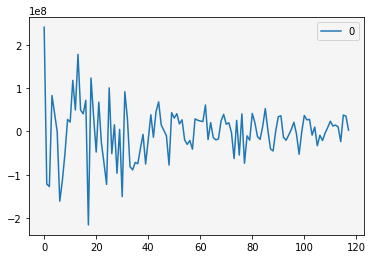

In [49]:
# Plot the residual errors
resid = pd.DataFrame(model_output.resid)
resid.plot()

                  0
count  1.180000e+02
mean  -8.019372e+05
std    6.198690e+07
min   -2.158842e+08
25%   -2.293946e+07
50%    3.859352e+06
75%    3.058083e+07
max    2.406329e+08


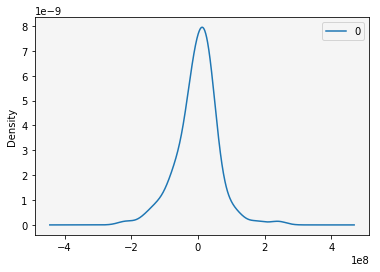

In [50]:
# Plot density of the residuals
resid.plot(kind='kde')
print(resid.describe())

<a id="hwes"></a>
### Holt-Winters Exponential Smoothing

In general, the Exponential Smoothing techniques are predicting future values of a time series by using a weighted average of all previous values, where the weights are getting adjusted with recent values getting higher weights and vice versa for the older historical values of the series. In other words, this family of methods assumes that more recent values of a time series are more important than older ones for predicting the future observations. That said, these models do not tend to work well with series that display _trend_ and _seasonal_ variations. As a reminder:

1) **Trend**: A time series is said to have a trend when there is a pattern in the way that series is changing over time. 

2) **Seasonality**: When a time series is displaying variations that occur at specific time intervals (e.g. every 4 months or every year), then we are saying that the series exhibits signs of seasonality.



This problem can be solved by using a more sophisticated type of exponential smoothing technique called **Holt-Winters Exponential Smoothing (HWES)**. 



The Holter-Winters exponential smoothing method is using an exponential window function where we are assigning decreasing weights in the past observations depending how 'far' they are compared to the prediction point in time, while at the same time taking into account concepts like trend and seasonality.

In [33]:
# Holt Winter's Exponential Smoothing (HWES)
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

train, test = tnf.split_test_train(united_kingdom_ts['Trade Value (US$)'], num_months_test=12)

In [34]:
test

Period
2019-01-01       64449
2019-02-01     1806453
2019-03-01      846430
2019-04-01      124498
2019-05-01      356123
2019-06-01    26184844
2019-07-01    26145772
2019-08-01      141569
2019-09-01    58903494
2019-10-01    74932830
2019-11-01    37295621
2019-12-01       43100
Name: Trade Value (US$), dtype: int64

In [35]:
rmse_results = {}
for s_i in range(2, 13):
    hwes_model = ExponentialSmoothing(train, seasonal='add', trend='add', seasonal_periods=s_i).fit()
    predicted_values = hwes_model.forecast(steps=len(test))
    rmse_results[s_i] = tnf.compute_RMSE(true_val=test, predicted_val=predicted_values, p_output=False)

In [36]:
sorted_rmse_results = sorted(rmse_results.items(), key=lambda kv: kv[1])
optimal_seasonal_prd = sorted_rmse_results[0][0]
optimal_seasonal_prd

8

In [37]:
hwes_model = ExponentialSmoothing(train, seasonal='add', trend='add', seasonal_periods=optimal_seasonal_prd)
hwes_model_fit = hwes_model.fit()
predicted_values_hwes = hwes_model_fit.forecast(steps=len(test))

In [38]:
pd.options.display.float_format = '{:.2f}'.format
print(predicted_values_hwes)

2019-01-01    7973071.07
2019-02-01   17786096.49
2019-03-01    7724730.41
2019-04-01   10106956.36
2019-05-01    -121148.84
2019-06-01   27595088.63
2019-07-01    7306142.57
2019-08-01   -2503318.95
2019-09-01    7973070.10
2019-10-01   17786095.52
2019-11-01    7724729.43
2019-12-01   10106955.38
Freq: MS, dtype: float64


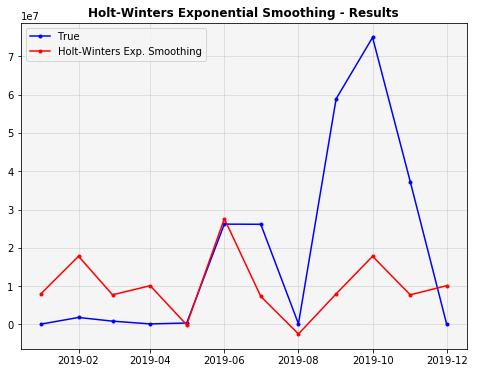

In [39]:
plt.figure(figsize=(8,6))
#plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, marker='.', color= 'blue', label='True')
plt.plot(predicted_values_hwes.index, predicted_values_hwes, marker='.', color='red', label='Holt-Winters Exp. Smoothing')
plt.grid(True, alpha=0.4)
plt.title('Holt-Winters Exponential Smoothing - Results', fontweight='bold')
plt.legend(loc='best')

In [40]:
tnf.compute_RMSE(true_val=test, predicted_val=predicted_values_hwes)

RMSE: 25272474.488934517


25272474.488934517